    ## First code to learn how to open and plot ERA5 data

In [1]:
import os
import pandas as pd 
import numpy as np

import iris
from iris.analysis import MEAN
from iris.analysis.stats import pearsonr
import iris.coord_categorisation

from scipy.stats import theilslopes #theil-sen trends

import matplotlib.pyplot as plt

In [2]:
# directories
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

#si estoy trabajando desde el servidor vegeta
ruta_a_archivos_ERA5_mensual = "../../../../../datos/ERA5_updated/mon" #ruta donde estan los archivos con datos de ERA5
ruta_a_resultados = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2024" #ruta donde se guardan los resultados del analisis de nubosidad

Current working directory: /home/nadia.testani/Doctorado/DoctoradoCodigos/codigos2024


/home/nadia.testani/anaconda3/envs/base_nadia/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/anaconda3/envs/base_nadia/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/anaconda3/envs/base_nadia/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/nadia.testani/anaconda3/envs/base_nadia/lib/python3.9/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


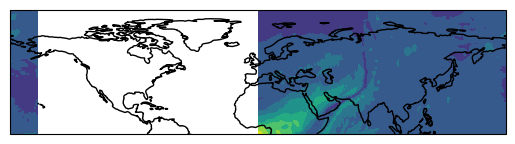

In [17]:
#open ERA5
ERA5_netcdf = iris.load_cube(f"{ruta_a_archivos_ERA5_mensual}/ERA5_precip.nc")

#time coord: convertion to dates
time_coord = ERA5_netcdf.coord('time')
time_axis = time_coord.units.num2date(time_coord.core_points())

#name of variable
variable_name = ERA5_netcdf.name()

#access to data
ERA5_data = ERA5_netcdf.data

#plot
plt.contourf(ERA5_data[1,:,:])

# regression
correlation_coefficient = pearsonr(ERA5_netcdf, ERA5_netcdf[:,0,0])
plt.contourf(correlation_coefficient.data)

#average one dimension 
ERA5_netcdf.collapsed('time',MEAN)

#slice 
ERA5_netcdf_subset = ERA5_netcdf[:,0:2,0:2]

#theil-sen trend
def calculate_theilsen_slope(y):
    slope, intercept, _, _ = theilslopes(y, range(len(y)), alpha=0.95)
    return slope, intercept
# Apply the Theil-Sen slope calculation to each grid point
trend_cube = ERA5_netcdf_subset[0:2,:,:].copy()
trend_cube.data = np.apply_along_axis(calculate_theilsen_slope, axis=0, arr=ERA5_netcdf_subset.data)

#filter theil-sen trend
def filter_theilsen_slope(y):
    #y: array 1D
    trend = calculate_theilsen_slope(y)[0] * np.arange(len(y)) + calculate_theilsen_slope(y)[1]
    filter_data = y - trend
    return filter_data
data_trend_filtered = ERA5_netcdf_subset[:,:,:].copy()
data_trend_filtered.data = np.apply_along_axis(filter_theilsen_slope, axis=0, arr=ERA5_netcdf_subset.data)

# calculate monthly mean
# Categorize the time coordinate by month
iris.coord_categorisation.add_month(ERA5_netcdf_subset, 'time', name='month')

# Calculate the monthly mean for each grid point
monthly_means = ERA5_netcdf_subset.aggregated_by('month', iris.analysis.MEAN)

# Filter monthly means --> anomalies
monthly_means_array = np.repeat(monthly_means.data, len(ERA5_netcdf_subset.data[:,1,1])/12, axis=0)
ERA5_anomalies = ERA5_netcdf_subset.data - monthly_means_array

In [ ]:
#to reshape arrays
np.reshape(ERA5_data, (ERA5_data.shape[0], -1))

#come back to original
detrended_data.reshape(ERA5_data.shape)